In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/brytserc/Surprise_410_Male.wav
/kaggle/input/brytserc/Neutral_020_Male.wav
/kaggle/input/brytserc/Neutral_410_Male.wav
/kaggle/input/brytserc/Angry_311_Male.wav
/kaggle/input/brytserc/Surprise_098_Female.wav
/kaggle/input/brytserc/Sad_640_Male.wav
/kaggle/input/brytserc/Surprise_003_Female.wav
/kaggle/input/brytserc/Disgust_368_Female.wav
/kaggle/input/brytserc/Angry_179_Male.wav
/kaggle/input/brytserc/Angry_553_Male.wav
/kaggle/input/brytserc/Surprise_484_Male.wav
/kaggle/input/brytserc/Angry_151_Male.wav
/kaggle/input/brytserc/Surprise_694_Male.wav
/kaggle/input/brytserc/Neutral_413_Male.wav
/kaggle/input/brytserc/Surprise_139_Female.wav
/kaggle/input/brytserc/Sad_298_Female.wav
/kaggle/input/brytserc/Angry_228_Male.wav
/kaggle/input/brytserc/Surprise_698_Male.wav
/kaggle/input/brytserc/Happy_586_Male.wav
/kaggle/input/brytserc/Disgust_238_Female.wav
/kaggle/input/brytserc/Fear_498_Male.wav
/kaggle/input/brytserc/Sad_473_Male.wav
/kaggle/input/brytserc/Surprise_596_Male

In [2]:
!pip install torch torchvision torchaudio transformers datasets scikit-learn matplotlib seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from transformers import AutoFeatureExtractor, Data2VecAudioModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')


DATA_PATH = "/kaggle/input/brytserc/"
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 20
MAX_LENGTH = 16000 * 5  
MODEL_NAME = "facebook/data2vec-audio-base-960h"
PATIENCE = 5  

2025-10-10 18:04:54.316985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760119494.530141      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760119494.585872      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [4]:
class EmotionDataset(Dataset):
  
    def __init__(self, features, labels, feature_extractor, max_length=MAX_LENGTH):
        self.features = features
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.max_length = max_length
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
       
        audio = self.features[idx]
        label = self.labels[idx]
        
     
        if not isinstance(audio, np.ndarray):
            audio = np.array(audio, dtype=np.float32)
        else:
            audio = audio.astype(np.float32)
        

        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
         
            pad_length = self.max_length - len(audio)
            audio = np.pad(audio, (0, pad_length), mode='constant', constant_values=0)
        
        return {
            'audio': torch.FloatTensor(audio),
            'label': torch.LongTensor([label])[0]
        }

def collate_fn(batch):
    
    audios = torch.stack([item['audio'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'audio': audios,
        'labels': labels
    }

In [ ]:
import librosa

def load_emotion_data(data_path):
   
    all_features = []
    all_labels = []
    
    print("Loading data...")
    
  
    all_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
    print(f"Found {len(all_files)} audio files")
    
    if len(all_files) == 0:
        raise ValueError(f"No .wav files found in {data_path}")
    

    emotion_counts = {emotion: 0 for emotion in EMOTIONS}
    
    for file in tqdm(all_files, desc="Loading audio files"):
        try:
           
            emotion_name = file.split('_')[0].lower()
            
            
            if emotion_name not in [e.lower() for e in EMOTIONS]:
                print(f"Warning: Unknown emotion '{emotion_name}' in file {file}")
                continue
            
           
            emotion_idx = [e.lower() for e in EMOTIONS].index(emotion_name)
            
  
            file_path = os.path.join(data_path, file)
            audio, sr = librosa.load(file_path, sr=16000)  
            
            all_features.append(audio)
            all_labels.append(emotion_idx)
            emotion_counts[EMOTIONS[emotion_idx]] += 1
            
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue
    
    print("\nEmotion distribution:")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion}: {count}")
    
    return all_features, np.array(all_labels)


features, labels = load_emotion_data(DATA_PATH)
print(f"\nTotal samples: {len(labels)}")

if len(labels) == 0:
    raise ValueError("No data loaded! Please check your data path and file format.")

print(f"Label distribution: {np.bincount(labels)}")

X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.4, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain samples: {len(y_train)} ({len(y_train)/len(labels)*100:.1f}%)")
print(f"Validation samples: {len(y_val)} ({len(y_val)/len(labels)*100:.1f}%)")
print(f"Test samples: {len(y_test)} ({len(y_test)/len(labels)*100:.1f}%)")


feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)

train_dataset = EmotionDataset(X_train, y_train, feature_extractor)
val_dataset = EmotionDataset(X_val, y_val, feature_extractor)
test_dataset = EmotionDataset(X_test, y_test, feature_extractor)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

print("\nData loading complete!")

Loading data...
Found 5215 audio files


Loading audio files: 100%|██████████| 5215/5215 [01:13<00:00, 70.85it/s]



Emotion distribution:
  angry: 745
  disgust: 745
  fear: 745
  happy: 745
  neutral: 745
  sad: 745
  surprise: 745

Total samples: 5215
Label distribution: [745 745 745 745 745 745 745]

Train samples: 3129 (60.0%)
Validation samples: 1043 (20.0%)
Test samples: 1043 (20.0%)


preprocessor_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]


Data loading complete!


In [6]:
class EmotionClassifier(nn.Module):
    
    def __init__(self, model_name, num_labels, dropout=0.3, freeze_encoder=False):
        super(EmotionClassifier, self).__init__()
        
   
        self.data2vec = Data2VecAudioModel.from_pretrained(model_name)
        
       
        if freeze_encoder:
            for param in self.data2vec.parameters():
                param.requires_grad = False
        
  
        hidden_size = self.data2vec.config.hidden_size
        
 
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_labels)
        )
        
    def forward(self, audio):
       
        outputs = self.data2vec(audio)
        
    
        hidden_states = outputs.last_hidden_state
        pooled = torch.mean(hidden_states, dim=1)
        
    
        logits = self.classifier(pooled)
        
        return logits


model = EmotionClassifier(
    model_name=MODEL_NAME,
    num_labels=len(EMOTIONS),
    dropout=0.3,
    freeze_encoder=False  
)

model = model.to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/373M [00:00<?, ?B/s]

Model initialized with 93691143 parameters
Trainable parameters: 93691143


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        audio = batch['audio'].to(device)
        labels = batch['labels'].to(device)
        
      
        optimizer.zero_grad()
        
     
        logits = model(audio)
        loss = criterion(logits, labels)
        
    
        loss.backward()
        optimizer.step()
        
     
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
        
   
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):

    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            audio = batch['audio'].to(device)
            labels = batch['labels'].to(device)
                        
            logits = model(audio)
            loss = criterion(logits, labels)
                        
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy, predictions, true_labels

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)


history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


best_val_accuracy = 0.0
best_model_state = None
best_epoch = 0
patience_counter = 0

print("\n" + "="*50)
print("Starting Training")
print("="*50)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
        
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    

    scheduler.step(val_acc)
    
  
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
 
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"✓ New best model! Validation accuracy: {val_acc:.4f}")
        
 
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_val_accuracy,
            'history': history
        }, 'best_emotion_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*50)
print("Training Complete!")
print(f"Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch}")
print("="*50)


model.load_state_dict(best_model_state)
print("\nBest model loaded for evaluation")


Starting Training

Epoch 1/20
--------------------------------------------------


Training:   0%|          | 0/196 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/373M [00:00<?, ?B/s]

Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 1.9160 | Train Acc: 0.2180
Val Loss: 1.7647 | Val Acc: 0.3576
✓ New best model! Validation accuracy: 0.3576

Epoch 2/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.36it/s]



Train Loss: 1.7064 | Train Acc: 0.3774
Val Loss: 1.5558 | Val Acc: 0.4027
✓ New best model! Validation accuracy: 0.4027

Epoch 3/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 1.5186 | Train Acc: 0.4452
Val Loss: 1.4105 | Val Acc: 0.4765
✓ New best model! Validation accuracy: 0.4765

Epoch 4/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 1.3334 | Train Acc: 0.5244
Val Loss: 1.1065 | Val Acc: 0.6194
✓ New best model! Validation accuracy: 0.6194

Epoch 5/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.38it/s]



Train Loss: 1.1397 | Train Acc: 0.6312
Val Loss: 1.0918 | Val Acc: 0.6443
✓ New best model! Validation accuracy: 0.6443

Epoch 6/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.9448 | Train Acc: 0.7085
Val Loss: 1.1497 | Val Acc: 0.6376
No improvement. Patience: 1/5

Epoch 7/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.38it/s]



Train Loss: 0.7999 | Train Acc: 0.7558
Val Loss: 0.8528 | Val Acc: 0.7306
✓ New best model! Validation accuracy: 0.7306

Epoch 8/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.6633 | Train Acc: 0.7996
Val Loss: 0.8137 | Val Acc: 0.7507
✓ New best model! Validation accuracy: 0.7507

Epoch 9/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.6264 | Train Acc: 0.8041
Val Loss: 1.0369 | Val Acc: 0.6865
No improvement. Patience: 1/5

Epoch 10/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.36it/s]



Train Loss: 0.5682 | Train Acc: 0.8309
Val Loss: 0.8930 | Val Acc: 0.7287
No improvement. Patience: 2/5

Epoch 11/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.37it/s]



Train Loss: 0.4814 | Train Acc: 0.8581
Val Loss: 0.9378 | Val Acc: 0.7373
No improvement. Patience: 3/5

Epoch 12/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.4887 | Train Acc: 0.8575
Val Loss: 0.9228 | Val Acc: 0.7421
No improvement. Patience: 4/5

Epoch 13/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.3914 | Train Acc: 0.8949
Val Loss: 0.7858 | Val Acc: 0.7824
✓ New best model! Validation accuracy: 0.7824

Epoch 14/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.3538 | Train Acc: 0.9044
Val Loss: 0.9043 | Val Acc: 0.7603
No improvement. Patience: 1/5

Epoch 15/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.3167 | Train Acc: 0.9147
Val Loss: 0.8677 | Val Acc: 0.7756
No improvement. Patience: 2/5

Epoch 16/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.3214 | Train Acc: 0.9128
Val Loss: 0.9788 | Val Acc: 0.7488
No improvement. Patience: 3/5

Epoch 17/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Train Loss: 0.3036 | Train Acc: 0.9169
Val Loss: 0.8652 | Val Acc: 0.7728
No improvement. Patience: 4/5

Epoch 18/20
--------------------------------------------------


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]


Train Loss: 0.2741 | Train Acc: 0.9239
Val Loss: 0.8819 | Val Acc: 0.7756
No improvement. Patience: 5/5

Early stopping triggered after 18 epochs

Training Complete!
Best validation accuracy: 0.7824 at epoch 13

Best model loaded for evaluation



Evaluating on Test Set


Validating: 100%|██████████| 66/66 [00:27<00:00,  2.39it/s]



Test Loss: 0.7814
Test Accuracy: 0.8025

Classification Report
              precision    recall  f1-score   support

       angry     0.8385    0.9060    0.8710       149
     disgust     0.6975    0.7584    0.7267       149
        fear     0.8908    0.7114    0.7910       149
       happy     0.9389    0.8255    0.8786       149
     neutral     0.7644    0.8926    0.8235       149
         sad     0.9444    0.7987    0.8655       149
    surprise     0.6353    0.7248    0.6771       149

    accuracy                         0.8025      1043
   macro avg     0.8157    0.8025    0.8048      1043
weighted avg     0.8157    0.8025    0.8048      1043



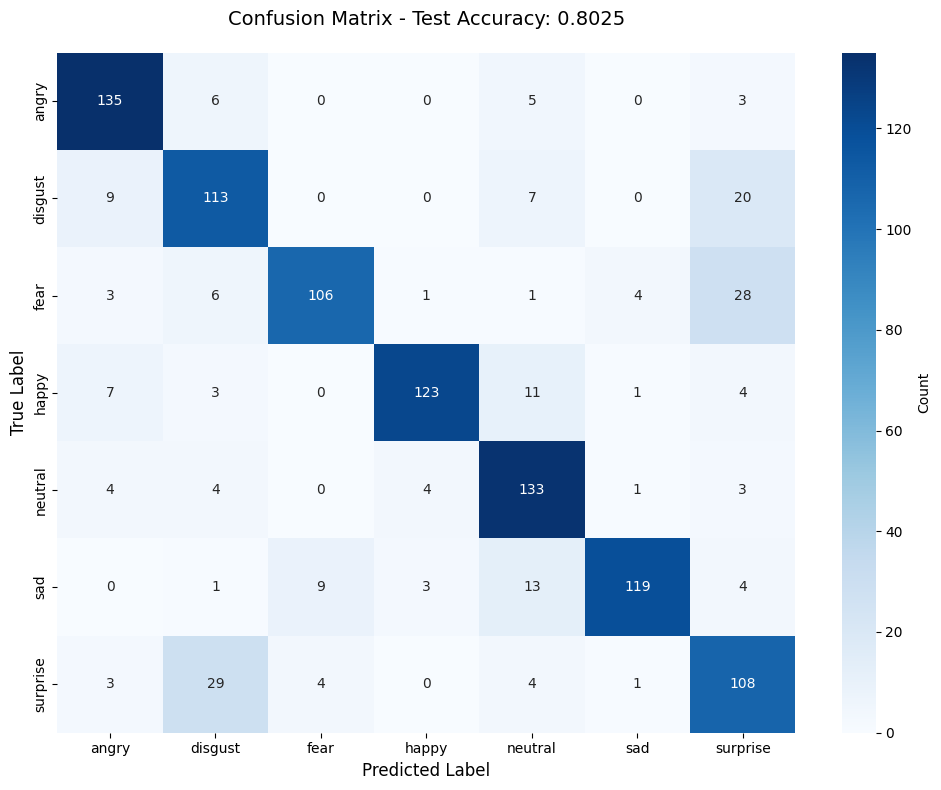


Confusion matrix saved as 'confusion_matrix.png'


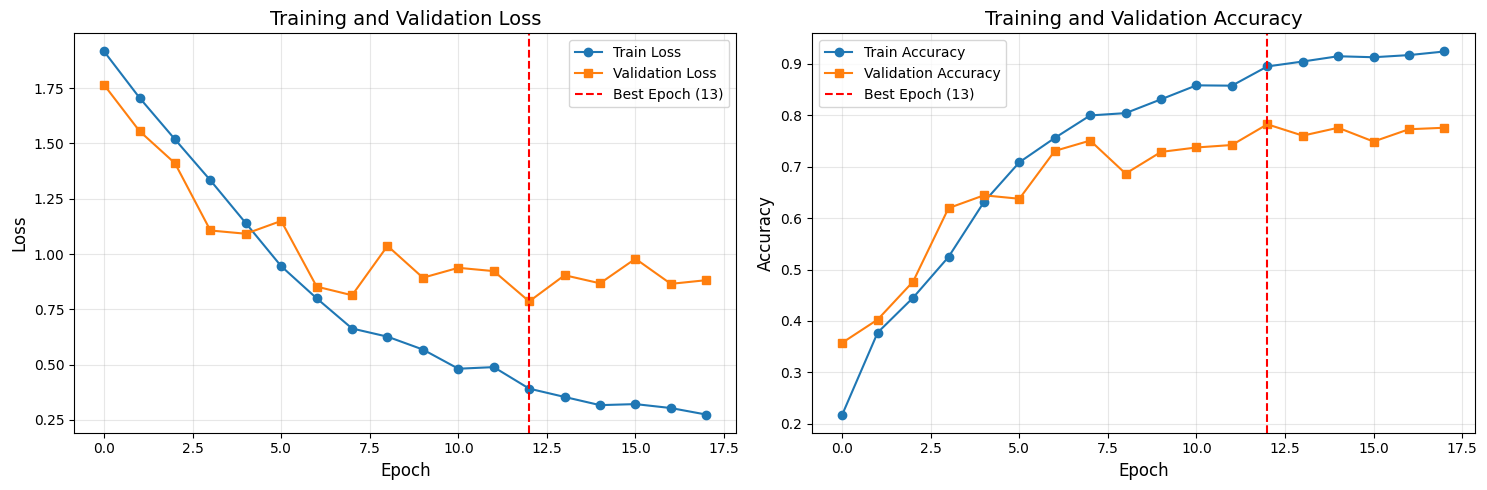

Training history saved as 'training_history.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("Evaluating on Test Set")
print("="*50)

test_loss, test_acc, test_predictions, test_true_labels = validate(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(
    test_true_labels, 
    test_predictions, 
    target_names=EMOTIONS,
    digits=4
))

cm = confusion_matrix(test_true_labels, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS,
    cbar_kws={'label': 'Count'}
)
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.4f}', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'confusion_matrix.png'")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
ax1.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
ax2.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history saved as 'training_history.png'")

In [ ]:

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_true_labels, test_predictions
)


results_df = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

results_df = results_df.round(4)
print("\n" + "="*50)
print("Per-Class Metrics")
print("="*50)
print(results_df.to_string(index=False))

results_df.to_csv('per_class_results.csv', index=False)
print("\nPer-class results saved to 'per_class_results.csv'")

summary = {
    'model_name': MODEL_NAME,
    'num_emotions': len(EMOTIONS),
    'emotions': EMOTIONS,
    'total_epochs': len(history['train_loss']),
    'best_epoch': best_epoch,
    'train_samples': len(y_train),
    'val_samples': len(y_val),
    'test_samples': len(y_test),
    'best_val_accuracy': best_val_accuracy,
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'max_length': MAX_LENGTH,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE
    }
}

with open('training_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

print("\nTraining summary saved to 'training_summary.pkl'")


print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Model: {MODEL_NAME}")
print(f"Total Epochs Trained: {len(history['train_loss'])}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("\nDataset Split:")
print(f"  Training: {len(y_train)} samples ({len(y_train)/len(labels)*100:.1f}%)")
print(f"  Validation: {len(y_val)} samples ({len(y_val)/len(labels)*100:.1f}%)")
print(f"  Test: {len(y_test)} samples ({len(y_test)/len(labels)*100:.1f}%)")
print("\nFiles saved:")
print("  - best_emotion_model.pth (best model checkpoint)")
print("  - confusion_matrix.png")
print("  - training_history.png")
print("  - per_class_results.csv")
print("  - training_summary.pkl")
print("="*50)


predictions_df = pd.DataFrame({
    'True_Label': [EMOTIONS[i] for i in test_true_labels],
    'Predicted_Label': [EMOTIONS[i] for i in test_predictions],
    'True_Label_Index': test_true_labels,
    'Predicted_Label_Index': test_predictions,
    'Correct': [t == p for t, p in zip(test_true_labels, test_predictions)]
})

predictions_df.to_csv('test_predictions.csv', index=False)
print("\nTest predictions saved to 'test_predictions.csv'")


Per-Class Metrics
 Emotion  Precision  Recall  F1-Score  Support
   angry     0.8385  0.9060    0.8710      149
 disgust     0.6975  0.7584    0.7267      149
    fear     0.8908  0.7114    0.7910      149
   happy     0.9389  0.8255    0.8786      149
 neutral     0.7644  0.8926    0.8235      149
     sad     0.9444  0.7987    0.8655      149
surprise     0.6353  0.7248    0.6771      149

Per-class results saved to 'per_class_results.csv'

Training summary saved to 'training_summary.pkl'

FINAL SUMMARY
Model: facebook/data2vec-audio-base-960h
Total Epochs Trained: 18
Best Epoch: 13
Best Validation Accuracy: 0.7824
Test Accuracy: 0.8025
Test Loss: 0.7814

Dataset Split:
  Training: 3129 samples (60.0%)
  Validation: 1043 samples (20.0%)
  Test: 1043 samples (20.0%)

Files saved:
  - best_emotion_model.pth (best model checkpoint)
  - confusion_matrix.png
  - training_history.png
  - per_class_results.csv
  - training_summary.pkl

Test predictions saved to 'test_predictions.csv'
